# Reworking inceptionV3 loaded model

### Load in Libraries

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import ResNet50 # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # type: ignore
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore


### Read in Data

In [3]:
# Import the utility functions
from animal_classification import get_data_generators, display_translated_labels

# Set the directory path for images
directory = r'csv/raw-img'

# Define a function for splitting data into train, validation, and test sets
def split_data(directory, test_size=0.2, val_size=0.2):
    # Get a list of image file paths and their corresponding labels
    image_paths = []
    labels = []
    class_labels = sorted(os.listdir(directory))  # Class labels from folder names
    
    # Assuming that the directory structure is class_name/image.jpg
    for class_label in class_labels:
        class_folder = os.path.join(directory, class_label)
        for image_name in os.listdir(class_folder):
            image_paths.append(os.path.join(class_folder, image_name))
            labels.append(class_label)
    
    # Split into train+val and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(image_paths, labels, test_size=test_size, random_state=42, stratify=labels)
    
    # Split train+val into separate train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size / (1 - test_size), random_state=42, stratify=y_train_val)
    
    return (X_train, X_val, X_test), (y_train, y_val, y_test)


# Load data split
(X_train, X_val, X_test), (y_train, y_val, y_test) = split_data(directory)

In [4]:
# Data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory, 
    classes=os.listdir(directory), 
    class_mode='categorical', 
    target_size=(224, 224), 
    batch_size=32
)

val_generator = val_datagen.flow_from_directory(
    directory, 
    classes=os.listdir(directory), 
    class_mode='categorical', 
    target_size=(224, 224), 
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    directory, 
    classes=os.listdir(directory), 
    class_mode='categorical', 
    target_size=(224, 224), 
    batch_size=32
)

Found 26179 images belonging to 10 classes.
Found 26179 images belonging to 10 classes.
Found 26179 images belonging to 10 classes.


### Load in Model

In [5]:
# Load ResNet50 (as ResNet18 isn't directly in Keras Applications)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model's layers
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [6]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Replace Flatten with Global Pooling
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout for regularization
outputs = Dense(len(os.listdir(directory)), activation='softmax')(x)  # Output for the number of classes

# Create the model
model = Model(inputs=base_model.input, outputs=outputs)

In [7]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=["accuracy", "Precision", "Recall"]
)

In [10]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6),
    # ModelCheckpoint('resnet50.keras', save_best_only=True)
]

In [12]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
819/819 [==============================] - 1363s 2s/step - loss: 1.3633 - accuracy: 0.5319 - precision: 0.7267 - recall: 0.3269 - val_loss: 5.6166 - val_accuracy: 0.2454 - val_precision: 0.2463 - val_recall: 0.2347 - lr: 0.0010
Epoch 2/5
819/819 [==============================] - 1305s 2s/step - loss: 1.3148 - accuracy: 0.5491 - precision: 0.7334 - recall: 0.3549 - val_loss: 3.8461 - val_accuracy: 0.3182 - val_precision: 0.3270 - val_recall: 0.3018 - lr: 0.0010
Epoch 3/5
819/819 [==============================] - 1322s 2s/step - loss: 1.2679 - accuracy: 0.5655 - precision: 0.7433 - recall: 0.3845 - val_loss: 3.5041 - val_accuracy: 0.1974 - val_precision: 0.2013 - val_recall: 0.1718 - lr: 0.0010
Epoch 4/5
819/819 [==============================] - 1303s 2s/step - loss: 1.2293 - accuracy: 0.5805 - precision: 0.7521 - recall: 0.4049 - val_loss: 2.5385 - val_accuracy: 0.3455 - val_precision: 0.3994 - val_recall: 0.2622 - lr: 0.0010
Epoch 5/5
819/819 [=============================

In [13]:
# Evaluate the model on the test set after training
y_test = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)
print(classification_report(y_test, y_pred, target_names=val_generator.class_indices))

819/819 [==============================] - 678s 826ms/step
              precision    recall  f1-score   support

        cane       0.19      0.23      0.20      4863
     cavallo       0.09      0.18      0.12      2623
    elefante       0.05      0.02      0.02      1446
    farfalla       0.08      0.12      0.09      2112
     gallina       0.12      0.18      0.15      3098
       gatto       0.06      0.01      0.02      1668
       mucca       0.06      0.03      0.04      1866
      pecora       0.07      0.01      0.01      1820
       ragno       0.18      0.14      0.15      4821
  scoiattolo       0.07      0.07      0.07      1862

    accuracy                           0.13     26179
   macro avg       0.10      0.10      0.09     26179
weighted avg       0.12      0.13      0.11     26179



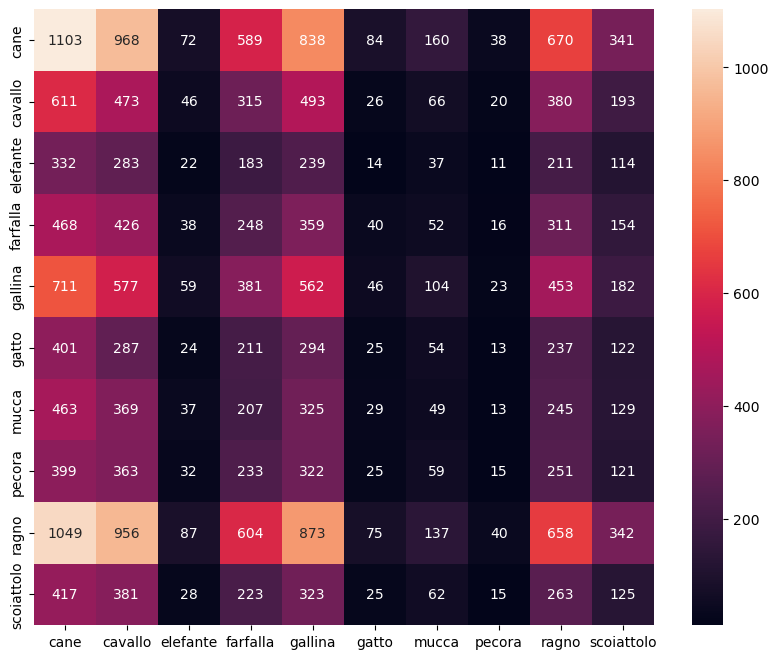

In [14]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=val_generator.class_indices, yticklabels=val_generator.class_indices)
plt.show()

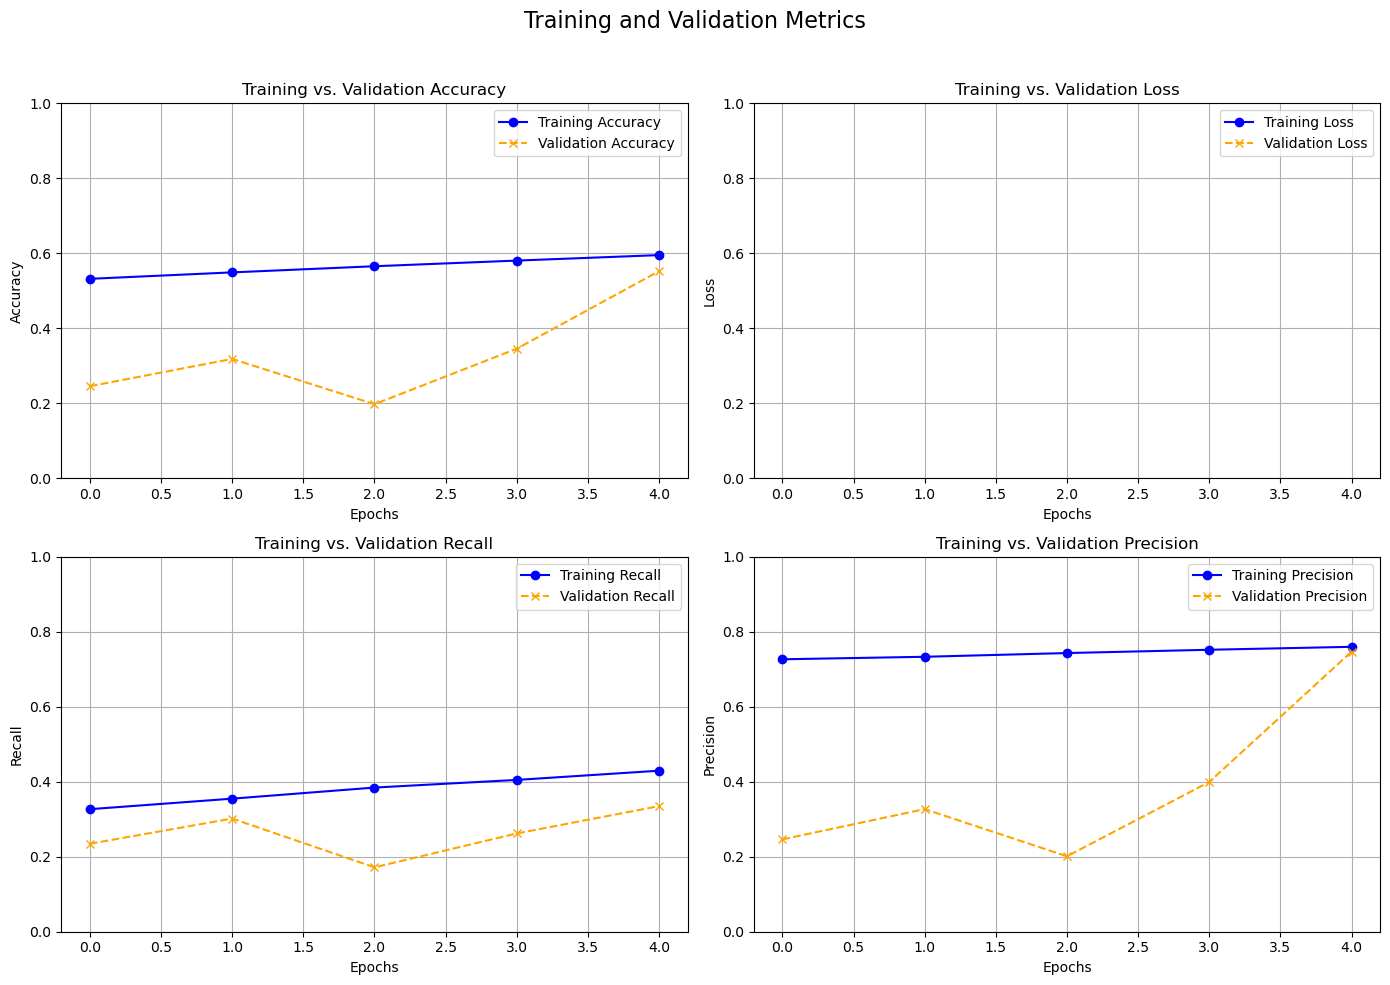

In [15]:
def plot_training_history(history, metrics, title="Training and Validation Metrics", save_path=None):
    valid_metrics = [metric for metric in metrics if metric in history.history]
    num_metrics = len(valid_metrics)
    rows = (num_metrics + 1) // 2
    fig, axs = plt.subplots(rows, 2, figsize=(14, 5 * rows))
    axs = axs.flatten()

    fig.suptitle(title, fontsize=16)

    for ax, metric in zip(axs, valid_metrics):
        ax.plot(history.history[metric], label=f'Training {metric.capitalize()}', color='blue', linestyle='-', marker='o')
        ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}', color='orange', linestyle='--', marker='x')
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'Training vs. Validation {metric.capitalize()}')
        ax.legend()
        ax.grid(True)
        ax.set_ylim(0, 1)

    for i in range(num_metrics, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

metrics = ['accuracy', 'loss', 'recall', 'precision']
plot_training_history(history, metrics)